In [2]:
# Let's make this notebook compatible for Python 2 and 3
from __future__ import division, print_function

# Import libraries
import pandas as pd
import numpy as np
import os
import math
import copy
import progressbar

# for visualization
import matplotlib.pyplot as plt

# to import module from parent directory
import sys
sys.path.append('..')

# Dataset API from sklearn
from sklearn import datasets

In [19]:
# Import helper functions
from utils import accuracy_score, train_test_split
from utils import to_categorical, normalize, Plot
from utils.misc import bar_widgets

from deep_learning.activation_functions import Sigmoid, ReLU, SoftPlus, LeakyReLU, TanH, ELU
from deep_learning.loss_functions import CrossEntropy, SquareLoss

from deep_learning.optimizers import Adam
from deep_learning.neural_network import NeuralNetwork
from deep_learning.layers import Dense, Dropout, Activation
from deep_learning.activation_functions import Sigmoid, LeakyReLU, Softmax

In [20]:
class Perceptron():
    """The Perceptron. One layer neural network classifier.

    Parameters:
    -----------
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    activation_function: class
        The activation that shall be used for each neuron.
        Possible choices: Sigmoid, ExpLU, ReLU, LeakyReLU, SoftPlus, TanH
    loss: class
        The loss function used to assess the model's performance.
        Possible choices: SquareLoss, CrossEntropy
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, n_iterations=20000, activation_function=Sigmoid, loss=SquareLoss, learning_rate=0.01):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.loss = loss()
        self.activation_func = activation_function()
        self.progressbar = progressbar.ProgressBar(widgets=bar_widgets)

    def fit(self, X, y):
        n_samples, n_features = np.shape(X)
        _, n_outputs = np.shape(y)

        # Initialize weights between [-1/sqrt(N), 1/sqrt(N)]
        limit = 1 / math.sqrt(n_features)
        self.W = np.random.uniform(-limit, limit, (n_features, n_outputs))
        self.w0 = np.zeros((1, n_outputs))

        for i in self.progressbar(range(self.n_iterations)):
            # Calculate outputs
            linear_output = X.dot(self.W) + self.w0
            y_pred = self.activation_func(linear_output)
            # Calculate the loss gradient w.r.t the input of the activation function
            error_gradient = self.loss.gradient(y, y_pred) * self.activation_func.gradient(linear_output)
            # Calculate the gradient of the loss with respect to each weight
            grad_wrt_w = X.T.dot(error_gradient)
            grad_wrt_w0 = np.sum(error_gradient, axis=0, keepdims=True)
            # Update weights
            self.W  -= self.learning_rate * grad_wrt_w
            self.w0 -= self.learning_rate  * grad_wrt_w0

    # Use the trained model to predict labels of X
    def predict(self, X):
        y_pred = self.activation_func(X.dot(self.W) + self.w0)
        return y_pred


Training: 100% [-----------------------------------------------] Time:  0:00:03


Accuracy: 0.9527824620573356


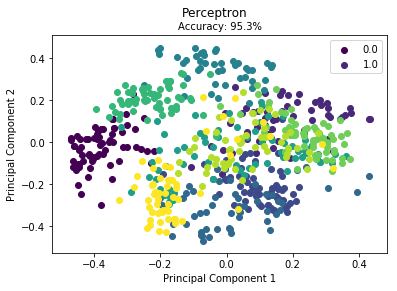

In [21]:
def main():
    data = datasets.load_digits()
    X = normalize(data.data)
    y = data.target

    # One-hot encoding of nominal y-values
    y = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, seed=1)

    # Perceptron
    clf = Perceptron(n_iterations=5000,
        learning_rate=0.001, 
        loss=CrossEntropy,
        activation_function=Sigmoid)
    clf.fit(X_train, y_train)

    y_pred = np.argmax(clf.predict(X_test), axis=1)
    y_test = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test, y_pred)

    print ("Accuracy:", accuracy)

    # Reduce dimension to two using PCA and plot the results
    Plot().plot_in_2d(X_test, y_pred, title="Perceptron", accuracy=accuracy, legend_labels=np.unique(y))


if __name__ == "__main__":
    main()

Training: N/A% [                                               ] ETA:  --:--:--


+-----+
| MLP |
+-----+
Input Shape: (64,)
+------------------------+------------+--------------+
| Layer Type             | Parameters | Output Shape |
+------------------------+------------+--------------+
| Dense                  | 33280      | (512,)       |
| Activation (LeakyReLU) | 0          | (512,)       |
| Dense                  | 262656     | (512,)       |
| Activation (LeakyReLU) | 0          | (512,)       |
| Dropout                | 0          | (512,)       |
| Dense                  | 262656     | (512,)       |
| Activation (LeakyReLU) | 0          | (512,)       |
| Dropout                | 0          | (512,)       |
| Dense                  | 262656     | (512,)       |
| Activation (LeakyReLU) | 0          | (512,)       |
| Dropout                | 0          | (512,)       |
| Dense                  | 5130       | (10,)        |
| Activation (Softmax)   | 0          | (10,)        |
+------------------------+------------+--------------+
Total Parameters: 826

Training: 100% [-----------------------------------------------] Time:  0:00:17


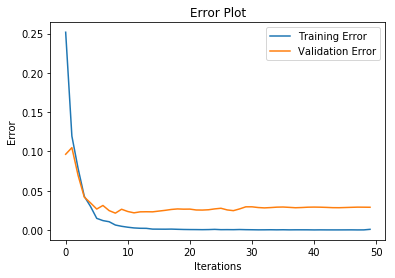

Accuracy: 0.9763231197771588


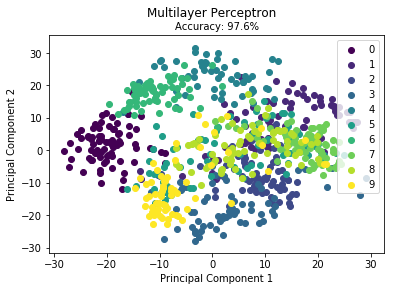

In [22]:
def main():

    optimizer = Adam()

    #-----
    # MLP
    #-----

    data = datasets.load_digits()
    X = data.data
    y = data.target

    # Convert to one-hot encoding
    y = to_categorical(y.astype("int"))

    n_samples, n_features = X.shape
    n_hidden = 512

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, seed=1)

    clf = NeuralNetwork(optimizer=optimizer,
                        loss=CrossEntropy,
                        validation_data=(X_test, y_test))

    clf.add(Dense(n_hidden, input_shape=(n_features,)))
    clf.add(Activation('leaky_relu'))
    clf.add(Dense(n_hidden))
    clf.add(Activation('leaky_relu'))
    clf.add(Dropout(0.25))
    clf.add(Dense(n_hidden))
    clf.add(Activation('leaky_relu'))
    clf.add(Dropout(0.25))
    clf.add(Dense(n_hidden))
    clf.add(Activation('leaky_relu'))
    clf.add(Dropout(0.25))
    clf.add(Dense(10))
    clf.add(Activation('softmax'))

    print ()
    clf.summary(name="MLP")
    
    train_err, val_err = clf.fit(X_train, y_train, n_epochs=50, batch_size=256)
    
    # Training and validation error plot
    n = len(train_err)
    training, = plt.plot(range(n), train_err, label="Training Error")
    validation, = plt.plot(range(n), val_err, label="Validation Error")
    plt.legend(handles=[training, validation])
    plt.title("Error Plot")
    plt.ylabel('Error')
    plt.xlabel('Iterations')
    plt.show()

    _, accuracy = clf.test_on_batch(X_test, y_test)
    print ("Accuracy:", accuracy)

    # Reduce dimension to 2D using PCA and plot the results
    y_pred = np.argmax(clf.predict(X_test), axis=1)
    Plot().plot_in_2d(X_test, y_pred, title="Multilayer Perceptron", accuracy=accuracy, legend_labels=range(10))


if __name__ == "__main__":
    main()